In [1]:
import numpy as np
import pandas as pd
import joblib
import os

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from plotly import express as px, graph_objects as go

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import time

from sklearn.model_selection import train_test_split

plt.rc("figure", figsize=(16, 8))
import seaborn as sns
sns.set()

%matplotlib inline

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

## 1. Data Import

In [4]:
train = pd.read_csv(os.getcwd()+"/data/train.csv")
test = pd.read_csv(os.getcwd()+"/data/test.csv")

In [5]:
#Delete columns of "lat","Lng"
train = train.drop(columns=["lat", "lng"])
test = test.drop(columns=["lat", "lng"])
train.info()

KeyError: "['lat' 'lng'] not found in axis"

## 2. EDA (Exploratory Data Analysis)

In [4]:
px.box(train, y="resale_price")

<AxesSubplot:xlabel='resale_price', ylabel='Count'>

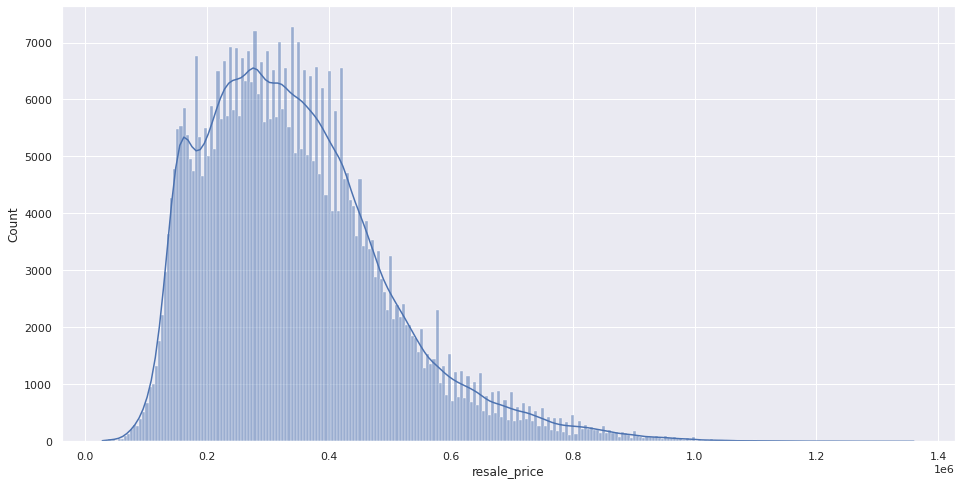

In [5]:
plt.rc("figure", figsize=(16, 8))
sns.histplot(train.resale_price, kde=True)

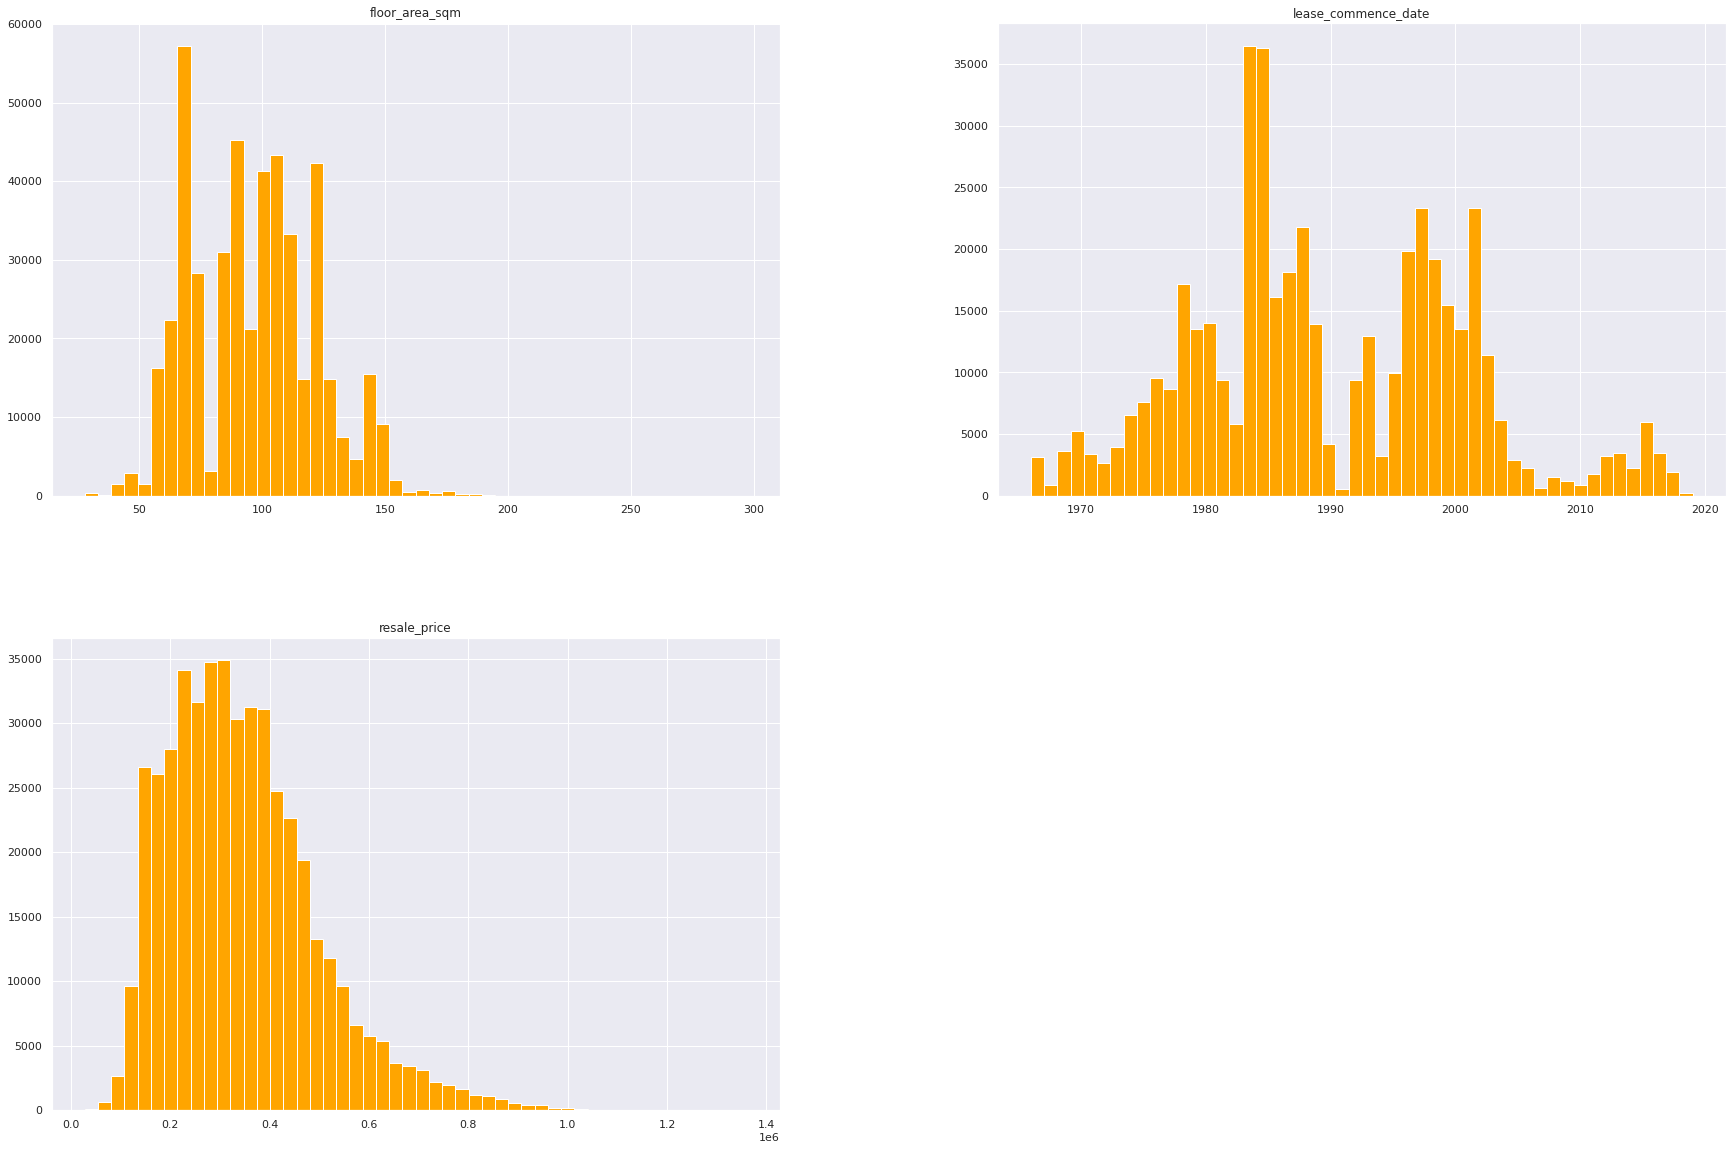

In [6]:
train.select_dtypes(np.number).hist(bins = 50,figsize =(30,20),color='orange');

In [7]:
corr_matrix = train.select_dtypes(np.number).corr()
corr = corr_matrix["resale_price"].sort_values(ascending = False)
# print(corr)
indexNames = corr[abs(corr.values) < 0.4].index.values
indexNames = np.setdiff1d(indexNames, ['Id','MSSubClass'])

pd.DataFrame(corr)

resale_price
resale_price             1.000000
floor_area_sqm           0.559482
lease_commence_date      0.447308

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



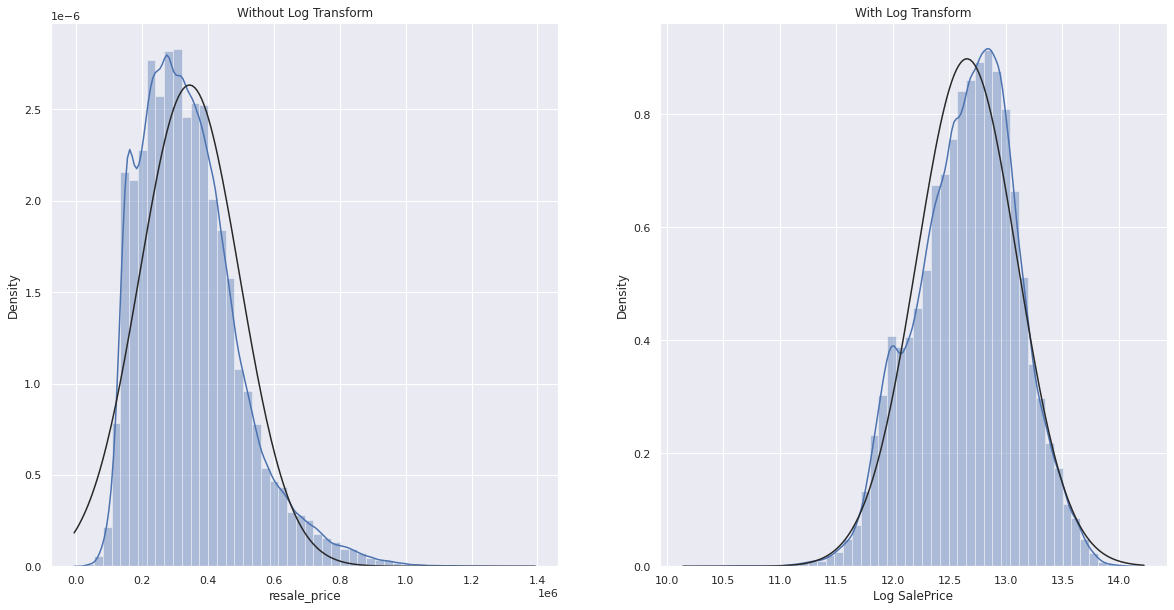

In [8]:
# train["resale_price"]
from scipy.stats import norm

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.distplot(train['resale_price'], kde=True, fit=norm)
plt.title("Without Log Transform")

plt.subplot(1, 2, 2)
sns.distplot(np.log(train['resale_price']), kde=True, fit=norm)
plt.xlabel("Log SalePrice")
plt.title("With Log Transform")

plt.show()

Text(0, 0.5, 'Count')

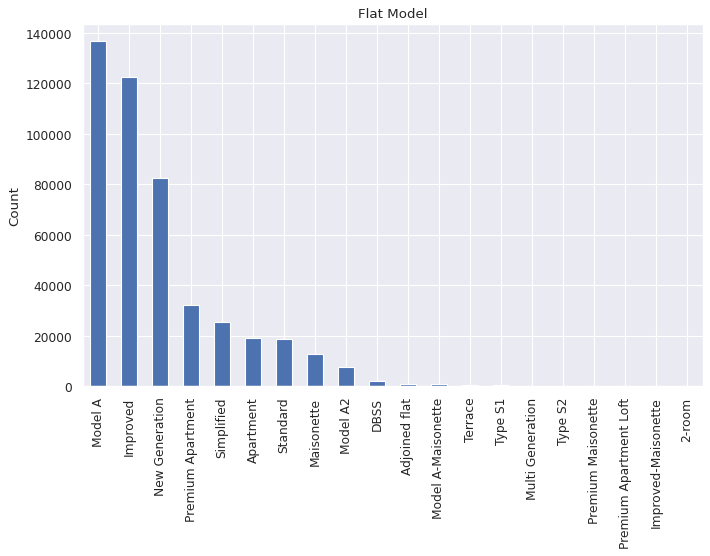

In [9]:
figure(figsize=(10, 6), dpi=80)

train['flat_model'].value_counts().plot(kind='bar')
plt.title("Flat Model")
plt.ylabel("Count")

## 3. Data Pre-processing

In [10]:
# Rename the column of 'month' to 'DATE'
train = train.rename(columns={"month":"DATE"})
test = test.rename(columns={"month":"DATE"})

# Generate categorical variables ('year','month',date) for DATE
train['year'] = train['DATE'].apply(lambda x : x.split('-')[0]).astype(int)
train['month'] = train['DATE'].apply(lambda x : x.split('-')[1]).astype(int)
train['date'] = pd.to_datetime(train['DATE'])

test['year'] = test['DATE'].apply(lambda x : x.split('/')[2]).astype(int)
test['month'] = test['DATE'].apply(lambda x : x.split('/')[0]).astype(int)
test['date'] = pd.to_datetime(train['DATE'])

# test.head()

In [11]:
# Generate categorical variable (quarter) from month

def month_to_quarter(x):
    if  x >= 1 and x <= 3:
        return 1
    elif x >= 4  and x <= 6:
        return 2
    elif x >= 7 and x <= 9:
        return 3
    elif x >= 10 and x <= 12:
        return 4
    
train['quarter'] = train["month"].apply(month_to_quarter)
test['quarter'] = test["month"].apply(month_to_quarter)

# test.head()

Text(0, 0.5, 'Count')

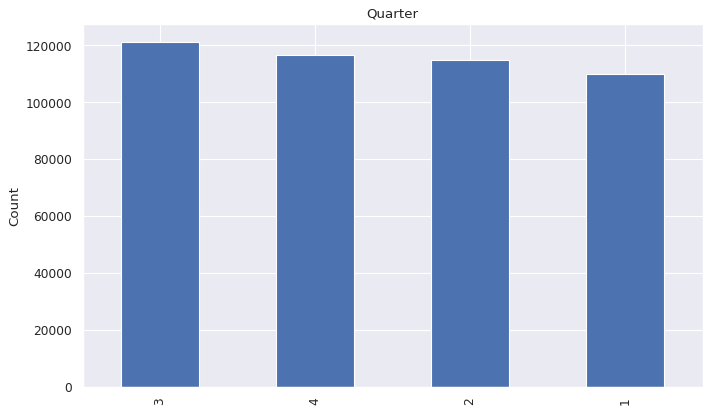

In [12]:
figure(figsize=(10, 6), dpi=80)

train['quarter'].value_counts().plot(kind='bar')
plt.title("Quarter")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

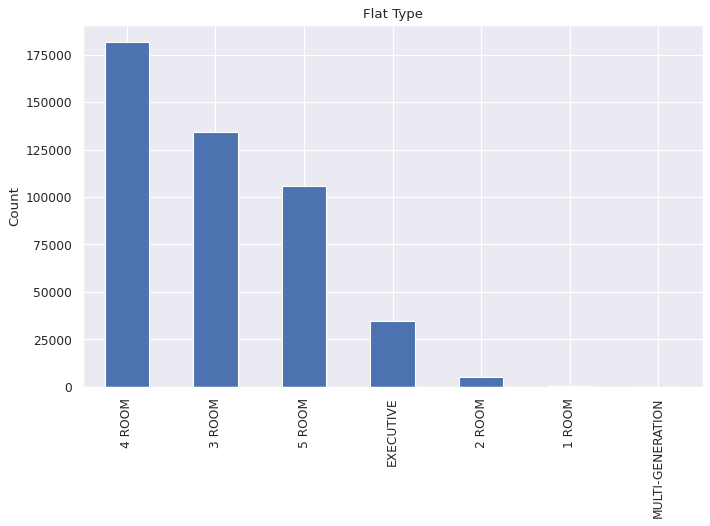

In [13]:
figure(figsize=(10, 6), dpi=80)

train['flat_type'].value_counts().plot(kind='bar')
plt.title("Flat Type")
plt.ylabel("Count")

Text(0.5, 0, 'Flat Type Category')

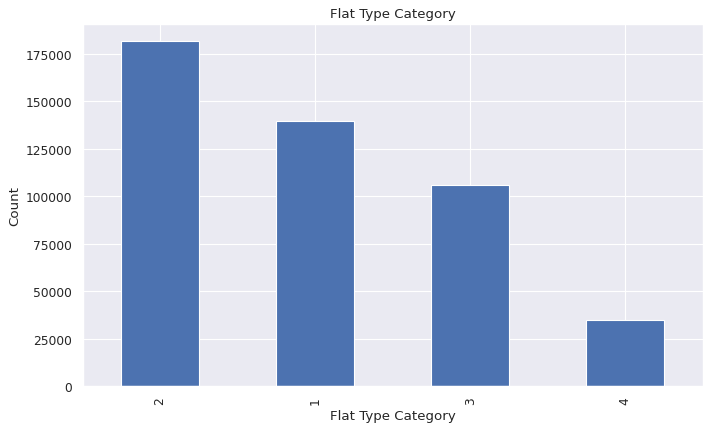

In [14]:
# Generate categorical variables (category_flat_type) from flat type
figure(figsize=(10, 6), dpi=80)

def catFT(x):
    # if x == '1 ROOM':
    #     return 1
    # elif x == '2 ROOM':
    #     return 2
    if x == '3 ROOM' or x =='2 ROOM' or x == '1 ROOM':
        return 1
    elif x == '4 ROOM':
        return 2
    elif x in ['5 ROOM' , 'MULTI-GENERATION']:
        return 3
    elif x == 'EXECUTIVE':
        return 4       
    
train['category_flat_type'] = train['flat_type'].apply(catFT)
test['category_flat_type'] = test['flat_type'].apply(catFT)

train['category_flat_type'].value_counts().plot(kind='bar')

plt.title("Flat Type Category")
plt.ylabel("Count")
plt.xlabel("Flat Type Category")

Text(0, 0.5, 'Count')

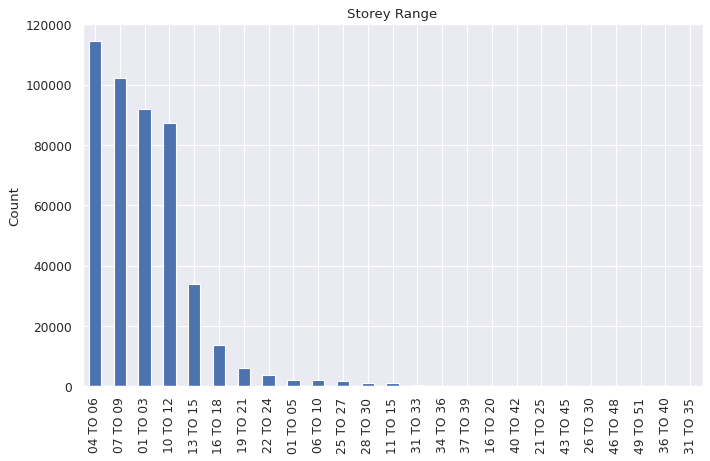

In [15]:
figure(figsize=(10, 6), dpi=80)

train['storey_range'].unique()
train['storey_range'].value_counts().plot(kind='bar')

plt.title("Storey Range")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

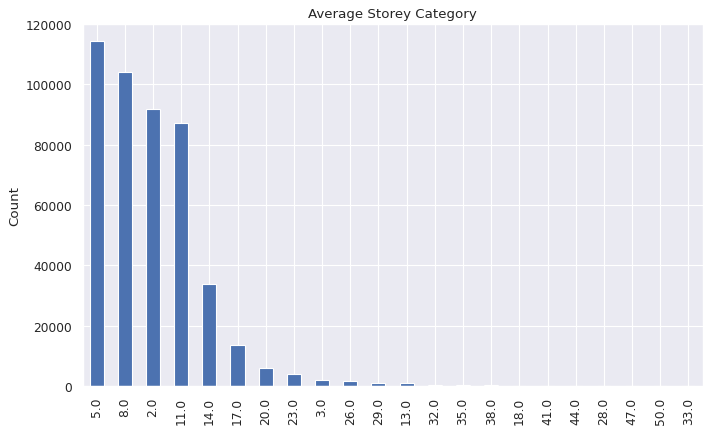

In [16]:
figure(figsize=(10, 6), dpi=80)

def avgSR(x):
  min_storey = int(x.split()[0])
  max_storey = int(x.split()[2])
  return (max_storey+min_storey)/2

train['avg_storey_range'] = train['storey_range'].apply(avgSR)
test['avg_storey_range'] = test['storey_range'].apply(avgSR)

train['avg_storey_range'].value_counts().plot(kind='bar')

plt.title("Average Storey Category")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

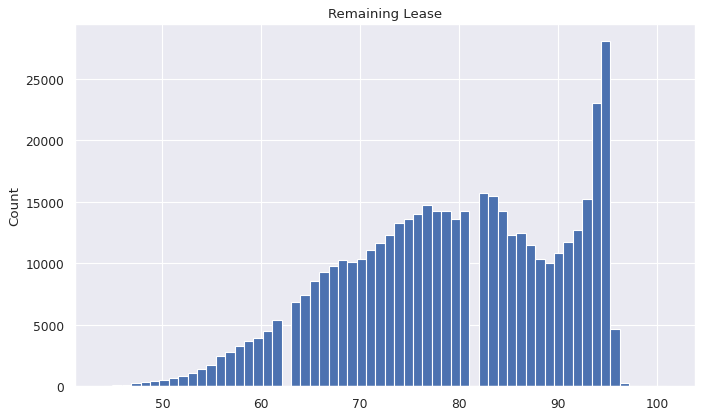

In [17]:
figure(figsize=(10, 6), dpi=80)

def modified_date(X):
    modifiedDate = 99 - (X['year'] - X['lease_commence_date'])
    X['remaining_lease'] = modifiedDate

modified_date(train)
modified_date(test)

train["remaining_lease"].hist(bins=60)

plt.title("Remaining Lease")
plt.ylabel("Count")

In [18]:
# Drop unneccesary columns
train = train.drop(columns=["DATE","flat_type","block","street_name","storey_range","lease_commence_date","date"])
test = test.drop(columns=["DATE","flat_type","block","street_name","storey_range","lease_commence_date","date"])

In [19]:
# Change numerical var's to strings to do one hot encoding

# train["year"] = train["year"].astype(str)
# train["month"] = train["month"].astype(str)
train["category_flat_type"] = train["category_flat_type"].astype(str)
# train["category_flat_type"] = train["category_flat_type"].astype(str)
# train["category_storey_range"] = train["category_storey_range"].astype(str)
# train["quarter"] = train["quarter"].astype(str)
# train["leaseband"] = train["leaseband"].astype(str)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462515 entries, 0 to 462514
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   town                462515 non-null  object 
 1   floor_area_sqm      462515 non-null  float64
 2   flat_model          462515 non-null  object 
 3   resale_price        462515 non-null  float64
 4   remaining_lease     462515 non-null  float64
 5   year                462515 non-null  int64  
 6   month               462515 non-null  int64  
 7   quarter             462515 non-null  int64  
 8   category_flat_type  462515 non-null  object 
 9   avg_storey_range    462515 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 35.3+ MB


In [20]:
#Do the same for test set
# test["year"] = test["year"].astype(str)
# test["month"] = test["month"].astype(str)
test["category_flat_type"] = test["category_flat_type"].astype(str)
# test["category_flat_type"] = test["category_flat_type"].astype(str)
# test["category_storey_range"] = test["category_storey_range"].astype(str)
# test["quarter"] = test["quarter"].astype(str)
# test["leaseband"] = test["leaseband"].astype(str)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115629 entries, 0 to 115628
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   town                115629 non-null  object 
 1   floor_area_sqm      115629 non-null  float64
 2   flat_model          115629 non-null  object 
 3   remaining_lease     115629 non-null  int64  
 4   year                115629 non-null  int64  
 5   month               115629 non-null  int64  
 6   quarter             115629 non-null  int64  
 7   category_flat_type  115629 non-null  object 
 8   avg_storey_range    115629 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 7.9+ MB


In [21]:
corr_matrix = train.select_dtypes(np.number).corr()
corr = corr_matrix["resale_price"].sort_values(ascending = False)
print(corr)
indexNames = corr[abs(corr.values) < 0.4].index.values
indexNames = np.setdiff1d(indexNames, ['Id','MSSubClass'])
pd.DataFrame(corr)

resale_price        1.000000
year                0.603606
floor_area_sqm      0.559482
avg_storey_range    0.282066
remaining_lease     0.077582
quarter             0.027145
month               0.026358
Name: resale_price, dtype: float64


resale_price
resale_price          1.000000
year                  0.603606
floor_area_sqm        0.559482
avg_storey_range      0.282066
remaining_lease       0.077582
quarter               0.027145
month                 0.026358

In [22]:
# Correlation matrix of features
fig = px.imshow(corr_matrix, text_auto=True)
fig.layout.height = 800
fig.layout.width = 800
fig.show()

In [23]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train["year"]=le.fit_transform(train["year"])
test["year"] = le.transform(test["year"])

In [24]:
#Categorical features
nominal_features = [
    'town','flat_model'
]

ordinal_features = [
    'category_flat_type', 'year', 'quarter', 'month',
]

#Numerical features
numerical_features = [
    'floor_area_sqm','avg_storey_range',"remaining_lease"
]

In [25]:
X = train.drop('resale_price', axis=1)
# y = np.log(train['resale_price'])
y = train['resale_price']

In [26]:
#One hot encoding for nominal features
dummies = pd.get_dummies(X[nominal_features]).sort_index()
X = pd.concat([X, dummies], axis=1)
X = X.drop(nominal_features, axis=1)

dummies = pd.get_dummies(test[nominal_features]).sort_index()
test = pd.concat([test, dummies], axis=1)
test = test.drop(nominal_features, axis=1)

In [27]:
#Ensure columns are same for Test as Train

# Get missing columns in the training test
missing_cols = set(X.columns ) - set( test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test = test[X.columns]

In [28]:
# Load libraries
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline,make_pipeline

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(323760, 53) (138755, 53) (323760,) (138755,)


In [29]:
#Min max scaler
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
# transform data
x_train[numerical_features + ordinal_features] = scaler.fit_transform(x_train[numerical_features + ordinal_features])
x_test[numerical_features + ordinal_features] = scaler.transform(x_test[numerical_features + ordinal_features])
test[numerical_features + ordinal_features] = scaler.transform(test[numerical_features + ordinal_features])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
x_pred = test

## 4. Model Selection
#### a)Linear Regression, b)Lasso Regression, c)Ridge Regression
#### d)Decision Tree, e)Random Forest, f)XGBoost

### 4-a.Linear Regression

In [31]:
reg = LinearRegression()

reg.fit(x_train, y_train)
x_test.shape

(138755, 53)

In [32]:
pred = reg.predict(x_test)

In [33]:
#R squared

from sklearn.metrics import mean_squared_error
reg.score(x_test, y_test)

0.8228471117858052

In [34]:
#RMSE
mean_squared_error(y_test, pred, squared=False)

63815.35194095817

### 4-b. Lasso Regression

In [35]:
from sklearn.metrics import r2_score 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error


perf = []
methods = []
r_squared_list=[]

In [36]:
# lasso regression
lasso = Lasso()
lasso.fit(x_train, y_train)
predictions = lasso.predict(x_test)

r_squared = r2_score(predictions, y_test)
r_squared_list.append(r_squared)

print("R2 Score:", r_squared)
methods.append('Lasso Regression')

# rmsle = np.sqrt(mean_squared_log_error(predictions, y_test))
rmse = np.sqrt(mean_squared_error(predictions, y_test))
# print("RMSLE:", rmsle)
print("RMSE:", rmse)
perf.append(rmse)

R2 Score: 0.784656017217691
RMSE: 63816.90495893434


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13747671381263.625, tolerance: 742690517327.9951



### 4-c. Ridge Regression

In [37]:
# Ridge regression
ridge = Ridge()
ridge.fit(x_train, y_train)
predictions = ridge.predict(x_test)

r_squared = r2_score(predictions, y_test)
r_squared_list.append(r_squared)

print("R2 Score:", r_squared)
methods.append('Ridge Regression')

# rmsle = np.sqrt(mean_squared_log_error(predictions, y_test))
rmse = np.sqrt(mean_squared_error(predictions, y_test))
# print("RMSLE:", rmsle)
print("RMSE:", rmse)
perf.append(rmse)

R2 Score: 0.7846933383691372
RMSE: 63816.71141383616


### 4-d. Decision Tree

In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

treeRegressor = DecisionTreeRegressor()

cross_val_score(treeRegressor, x_train, y_train, cv=5)

array([0.94140899, 0.9399876 , 0.94218896, 0.9414524 , 0.94106464])

In [39]:
treeRegressor.fit(x_train, y_train)
pred = treeRegressor.predict(x_test)

In [40]:
#R squared
treeRegressor.score(x_test,y_test)

0.9433076416689907

In [41]:
#RMSE
mean_squared_error(y_test, pred, squared=False)

36100.507879872064

### 4-e. Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

#without hyperparameter tuning

model_rf = rf.fit(x_train, y_train)
pred = model_rf.predict(x_test)

In [43]:
#RMSE
mean_squared_error(y_test, pred, squared=False)

27381.77586855927

### 4-e. XGBoost

In [44]:
# import xgboost as xgb
from xgboost import XGBRegressor as xgb
import xgboost

In [45]:
# base-line
start = time.time()
print(f"start timer...\n")

params = {
    'booster':'gbtree',
    'max_depth':8, #default
    'min_child_weight':1, #default
    'eta':0.3, #default
    'tree_method':'auto',
    'objective':'reg:squarederror',
    'eval_metric': 'rmse',
    'predictor':'cpu_predictor'
}

dtrain = xgboost.DMatrix(x_train, label=y_train)
dtest = xgboost.DMatrix(x_test, label=y_test)
results_dict = {}
model = xgboost.train(params=params,
                 dtrain=dtrain,
                 num_boost_round=1000,
                 early_stopping_rounds=4,
                 evals=[(dtrain, 'train'),(dtest,'test')],
                 evals_result = results_dict)

end = time.time()
print("train time (mins):", (end - start)/60)

start timer...

[0]	train-rmse:266978.84375	test-rmse:267507.15625
[1]	train-rmse:191526.14062	test-rmse:191987.81250
[2]	train-rmse:139543.07812	test-rmse:139963.42188
[3]	train-rmse:104342.10938	test-rmse:104766.96094
[4]	train-rmse:81097.90625	test-rmse:81517.78125
[5]	train-rmse:65956.10156	test-rmse:66450.53125
[6]	train-rmse:56062.39844	test-rmse:56606.19531
[7]	train-rmse:49762.77734	test-rmse:50353.96094
[8]	train-rmse:45767.08984	test-rmse:46443.20312
[9]	train-rmse:43029.39453	test-rmse:43677.94922
[10]	train-rmse:41008.96875	test-rmse:41666.76172
[11]	train-rmse:39452.88672	test-rmse:40136.33594
[12]	train-rmse:38448.64844	test-rmse:39165.53125
[13]	train-rmse:37625.90234	test-rmse:38336.65234
[14]	train-rmse:36737.10156	test-rmse:37493.32812
[15]	train-rmse:36061.81641	test-rmse:36820.11719
[16]	train-rmse:35348.01172	test-rmse:36115.80469
[17]	train-rmse:34815.05469	test-rmse:35599.67578
[18]	train-rmse:34354.12891	test-rmse:35119.04297
[19]	train-rmse:33966.07422	test-rms

In [46]:
pred = model.predict(xgboost.DMatrix(x_test))

In [47]:
#RMSE
mean_squared_error(y_test, pred, squared=False)

25058.66825947043

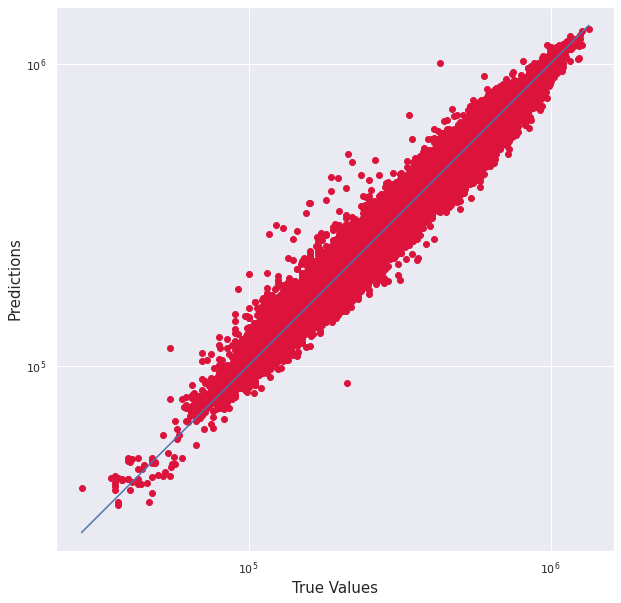

In [48]:
# Model Accuracy
true_value = y_test
predicted_value = model.predict(xgboost.DMatrix(x_test))

plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()


In [49]:
fscore = model.get_fscore(fmap='')
data_items = fscore.items()
data_list = list(data_items)
f_score = pd.DataFrame(data_list)
f_score.rename(columns={1: "fscore"},inplace=True)
f_score = f_score.set_index(f_score[0])
f_score = f_score.drop(columns=[0])
f_score.sort_values(ascending=False,by="fscore")

fscore
0                                         
floor_area_sqm                     17336.0
remaining_lease                    16577.0
year                               11818.0
month                              11402.0
avg_storey_range                    9363.0
flat_model_Improved                  777.0
town_BUKIT MERAH                     676.0
town_BEDOK                           670.0
flat_model_Model A                   650.0
town_JURONG WEST                     637.0
town_TOA PAYOH                       597.0
town_KALLANG/WHAMPOA                 594.0
town_GEYLANG                         554.0
category_flat_type                   507.0
town_HOUGANG                         491.0
town_TAMPINES                        478.0
town_QUEENSTOWN                      468.0
town_WOODLANDS                       463.0
town_SERANGOON                       457.0
town_BUKIT BATOK                     447.0
town_CLEMENTI                        409.0
flat_model_Apartment                 405.0
town_ANG MO KIO                      391.0
flat_model_Premium Apartment         388.0
town_JURONG EAST                     371.0
town_BUKIT PANJANG                   347.0
town_BISHAN                          341.0
town_YISHUN                          326.0
town_CHOA CHU KANG                   318.0
flat_model_New Generation            316.0
town_PASIR RIS                       293.0
town_SENGKANG                        258.0
flat_model_Standard                  246.0
flat_model_Maisonette                180.0
flat_model_Simplified                161.0
town_PUNGGOL                         137.0
flat_model_Adjoined flat             132.0
flat_model_DBSS                      130.0
town_CENTRAL AREA                    128.0
town_MARINE PARADE                    84.0
flat_model_Model A2                   76.0
town_SEMBAWANG                        72.0
town_BUKIT TIMAH                      53.0
flat_model_Terrace                    50.0
flat_model_Model A-Maisonette         42.0
flat_model_Improved-Maisonette        33.0
flat_model_Multi Generation           26.0
flat_model_Type S2                    25.0
flat_model_Premium Maisonette         22.0
flat_model_Type S1                    22.0
flat_model_Premium Apartment Loft     18.0
flat_model_2-room                      7.0

Text(0.5, 1.0, 'Feature Importance')

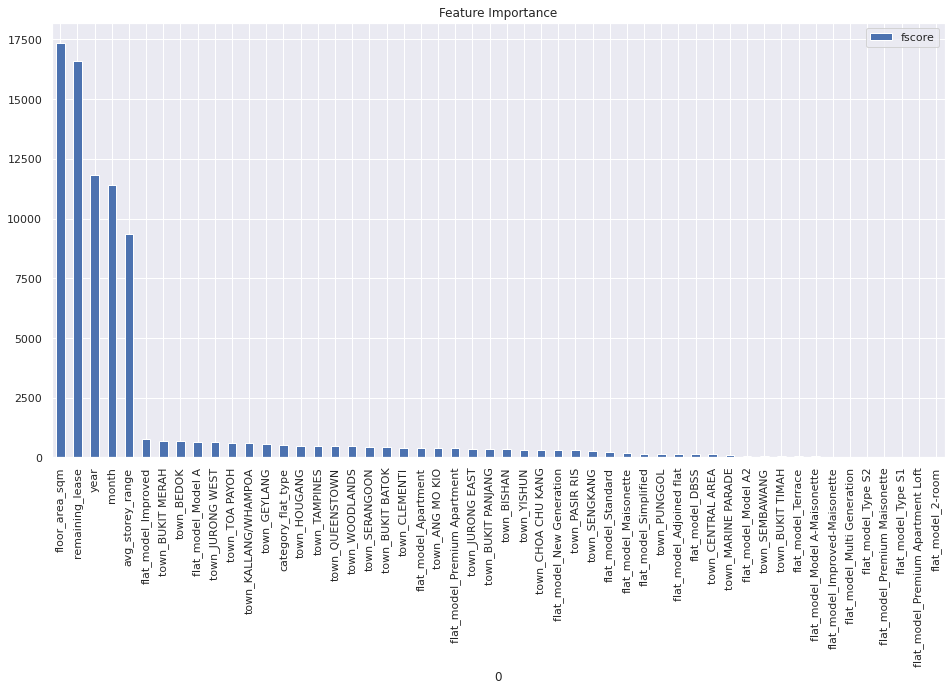

In [50]:
#Feature Importance
f_score.sort_values(ascending=False, by='fscore').plot(kind='bar')
plt.title('Feature Importance')

## 5. Hyper Parameter Tuning
#### a)RandomizedSearchCV, b)GridSearchCV

### 5-a. RandomizedSearchCV
#### Did comment-out to avoid over hour-long running time

In [51]:
# random_params = {
#     #General Params
#     'booster': ['gbtree'],
#     #Booster Params
#     'eta':[0.3,0.1],
#     'min_child_weight':[1,3],
#     'max_depth':[5,6,7,8,9,10],
#     'colsample_bytree':[0.5,1.0],
#     'subsample':[0.5,1.0],
#     #Learning Task Params
#     'objective':['reg:squarederror'],
#     'eval_metric': ['rmse'],
#     'predictor':['cpu_predictor'],
#     'n_estimators':[20],
#             }

In [52]:
# xgb_r = xgb.XGBRegressor()

# xgb_random = RandomizedSearchCV(xgb_r, random_params, cv=5, n_jobs=1,scoring='neg_root_mean_squared_error')
# xgb_random.fit(x_test,y_test,
#              early_stopping_rounds=5,
#              eval_set=[(x_test, y_test)],
#              eval_metric='rmse',
#              verbose=0)
# xgb_random.best_params_, -xgb_random.best_score_

### 5-b. GridSearchCV
#### Did comment-out to avoid over hour-long running time

In [53]:
# #tuning target parameters
# tune_params = {
#     #General Params
#     'booster': ['gbtree'],
#     #Booster Params
#     'eta':[0.3,0.1],
#     'min_child_weight':[1,3],
#     # 'max_depth':[5,6,7,8,9,10],
#     # 'colsample_bytree':[0.5,1.0],
#     # 'subsample':[0.5,1.0],
#     #Learning Task Params
#     'objective':['reg:squarederror'],
#     'eval_metric': ['rmse'],
#     'predictor':['cpu_predictor'],
#     'n_estimators':[1000],
#             }

#### Step1
##### Tuning Target: eta, ,min_child_weight

In [54]:
# step1 = {
#     #General Params
#     'booster': ['gbtree'],
#     #Booster Params
#     'eta':[0.3,0.1], #←Tuning target
#     'min_child_weight':[1,3], #←Tuning target
#     # 'max_depth':[5,6,7,8,9,10],
#     # 'colsample_bytree':[0.5,1.0],
#     # 'subsample':[0.5,1.0],
#     #Learning Task Params
#     'objective':['reg:squarederror'],
#     'eval_metric': ['rmse'],
#     'predictor':['cpu_predictor'],
#     'n_estimators':[1000],
#             }

In [55]:
# xgb1 = xgboost.XGBRegressor()

# xgb_grid = GridSearchCV(xgb1, step1, cv=5, n_jobs=1,scoring='neg_root_mean_squared_error')
# xgb_grid.fit(x_test,y_test,
#              early_stopping_rounds=5,
#              eval_set=[(x_test, y_test)],
#              eval_metric='rmse',
#              verbose=0)
# xgb_grid.best_params_, -xgb_grid.best_score_

#### Step2
##### Tuning Target: max_depth

In [56]:
# step2 = {
#     #General Params
#     'booster': ['gbtree'],
#     #Booster Params
#     'eta':[0.3], # best param
#     'min_child_weight':[1], #best param
#     'max_depth':[5,6,7,8,9,10], #←Tuning target
#     # 'colsample_bytree':[0.5,1.0],
#     # 'subsample':[0.5,1.0],
#     #Learning Task Params
#     'objective':['reg:squarederror'],
#     'eval_metric': ['rmse'],
#     'predictor':['cpu_predictor'],
#     'n_estimators':[1000],
#             }

In [57]:
# xgb2 = xgboost.XGBRegressor()

# xgb_grid2 = GridSearchCV(xgb2, step2, cv=5, n_jobs=1,scoring='neg_root_mean_squared_error')
# xgb_grid2.fit(x_test,y_test,
#              early_stopping_rounds=5,
#              eval_set=[(x_test, y_test)],
#              eval_metric='rmse',
#              verbose=0)
# xgb_grid2.best_params_, -xgb_grid2.best_score_

#### Step3
##### Tuning Target: colsample_bytree, subsample

In [58]:
# step3 = {
#     #General Params
#     'booster': ['gbtree'],
#     #Booster Params
#     'eta':[0.3], # best param
#     'min_child_weight':[1], #best param
#     'max_depth':[8], #best param
#     'colsample_bytree':[0.5,1.0], #←Tuning target
#     'subsample':[0.5,1.0], #←Tuning target
#     #Learning Task Params
#     'objective':['reg:squarederror'],
#     'eval_metric': ['rmse'],
#     'predictor':['cpu_predictor'],
#     'n_estimators':[1000],
#             }

In [59]:
# xgb3 = xgboost.XGBRegressor()

# xgb_grid3 = GridSearchCV(xgb3, step3, cv=5, n_jobs=1,scoring='neg_root_mean_squared_error')
# xgb_grid3.fit(x_test,y_test,
#              early_stopping_rounds=5,
#              eval_set=[(x_test, y_test)],
#              eval_metric='rmse',
#              verbose=0)
# xgb_grid3.best_params_, -xgb_grid3.best_score_

## 6. Prediction with test data
### Model: XGBoost after hyper parameter tuning

In [60]:
## After Hyperparameter tuning
start = time.time()
print(f"start timer...\n")

best_params = {
    #General Params
    'booster': 'gbtree',
    #Booster Params
    'eta':0.3, #best param
    'min_child_weight':1, #best param
    'max_depth':8, #best param
    'colsample_bytree':1.0, #best param
    'subsample':1.0, #best param
    #Learning Task Params
    'tree_method':'auto',
    'objective':'reg:squarederror',
    'eval_metric': 'rmse',
    'predictor':'cpu_predictor',
            }

dtrain = xgboost.DMatrix(x_train, label=y_train)
dtest = xgboost.DMatrix(x_test, label=y_test)
results_dict = {}
model2 = xgboost.train(params=best_params,
                 dtrain=dtrain,
                 num_boost_round=1000,
                 early_stopping_rounds=10,
                 evals=[(dtrain, 'train'),(dtest,'test')],
                 evals_result = results_dict)

end = time.time()
print("train time (mins):", (end - start)/60)

start timer...

[0]	train-rmse:266978.84375	test-rmse:267507.15625
[1]	train-rmse:191526.14062	test-rmse:191987.81250
[2]	train-rmse:139543.07812	test-rmse:139963.42188
[3]	train-rmse:104342.10938	test-rmse:104766.96094
[4]	train-rmse:81097.90625	test-rmse:81517.78125
[5]	train-rmse:65956.10156	test-rmse:66450.53125
[6]	train-rmse:56062.39844	test-rmse:56606.19531
[7]	train-rmse:49762.77734	test-rmse:50353.96094
[8]	train-rmse:45767.08984	test-rmse:46443.20312
[9]	train-rmse:43029.39453	test-rmse:43677.94922
[10]	train-rmse:41008.96875	test-rmse:41666.76172
[11]	train-rmse:39452.88281	test-rmse:40136.33594
[12]	train-rmse:38448.64844	test-rmse:39165.53125
[13]	train-rmse:37625.90234	test-rmse:38336.65234
[14]	train-rmse:36737.10156	test-rmse:37493.32812
[15]	train-rmse:36061.82031	test-rmse:36820.11719
[16]	train-rmse:35348.01172	test-rmse:36115.80469
[17]	train-rmse:34815.05469	test-rmse:35599.67578
[18]	train-rmse:34354.12891	test-rmse:35119.04297
[19]	train-rmse:33966.07031	test-rms

In [61]:
pred = model2.predict(xgboost.DMatrix(x_test))

In [62]:
#RMSE
mean_squared_error(y_test, pred, squared=False)

24936.239929775376

In [63]:
#R squared
r_squared = r2_score(pred, y_test)
r_squared

0.9723100126999471

In [64]:
#prediction with test data for Kaggle submission
y_pred = model.predict(xgboost.DMatrix(x_pred))
y_pred

array([274669.88, 514566.2 , 379574.84, ..., 454488.2 , 193946.72,
       203482.33], dtype=float32)

In [65]:
submission = pd.DataFrame.from_dict({'id': range(1, len(y_pred)+1), 'resale_price': y_pred})
submission

id   resale_price
0            1  274669.875000
1            2  514566.187500
2            3  379574.843750
3            4  753531.312500
4            5  154994.109375
...        ...            ...
115624  115625  191308.234375
115625  115626  168456.093750
115626  115627  454488.187500
115627  115628  193946.718750
115628  115629  203482.328125

[115629 rows x 2 columns]

### End